In [88]:
import cv2, dlib
import numpy as np
from imutils import face_utils
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
IMG_SIZE = (224, 224)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('models/model.dat')

model = load_model('models/my_model.h5')
# model.summary()

In [90]:
def crop_eye(img, eye_points):
  x1, y1 = np.amin(eye_points, axis=0)
  x2, y2 = np.amax(eye_points, axis=0)
  cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

  w = (x2 - x1) * 1.2
  h = w * IMG_SIZE[1] / IMG_SIZE[0]

  margin_x, margin_y = w / 2, h / 2

  min_x, min_y = int(cx - margin_x), int(cy - margin_y)
  max_x, max_y = int(cx + margin_x), int(cy + margin_y)

  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

  eye_img = img_ori[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

  return eye_img, eye_rect


In [91]:
img_ori = cv2.imread('minio/id-image/1308672.jpeg')

In [92]:
img_ori.shape

(1275, 993, 3)

In [93]:
img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

img = img_ori.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

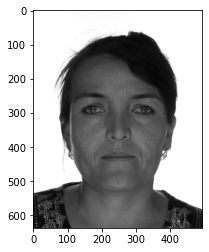

In [94]:
plt.imshow(img_ori)
plt.imshow(gray, cmap='gray')

In [95]:
faces = detector(gray)

In [96]:
face = faces[0]

In [99]:
shapes = predictor(gray, face)
shapes = face_utils.shape_to_np(shapes)

eye_img_l, eye_rect_l = crop_eye(img_ori, eye_points=shapes[36:42])
eye_img_r, eye_rect_r = crop_eye(img_ori, eye_points=shapes[42:48])

eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
eye_img_r = cv2.flip(eye_img_r, flipCode=1)
print(eye_img_l.shape)
cv2.imshow('l', eye_img_l)
cv2.imshow('r', eye_img_r)
cv2.waitKey(1000)


/var/folders/1t/88mj6ftx7kzcj3p0wtqxbcl40000gn/T/ipykernel_18561/2737526102.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)


(224, 224, 3)


-1

In [100]:
# input image size is 224x224x3 (RGB)
eye_input_l = eye_img_l.copy().reshape(1, *IMG_SIZE, 3).astype(np.float32) / 255
eye_input_r = eye_img_r.copy().reshape(1, *IMG_SIZE, 3).astype(np.float32) / 255

In [101]:
pred_l = model.predict(eye_input_l)
pred_r = model.predict(eye_input_r)

2022-05-05 13:20:22.988811: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-05 13:20:23.131675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [103]:
pred_r

array([[1.]], dtype=float32)

In [104]:
# visualize
state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

state_l = state_l % pred_l
state_r = state_r % pred_r

cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 41,  51,  63],
        [ 42,  55,  67],
        [ 38,  48,  59],
        ...,
        [ 41,  50,  70],
        [ 42,  45,  52],
        [ 49,  45,  50]],

       [[ 47,  57,  79],
        [ 36,  52,  69],
        [ 45,  61,  71],
        ...,
        [ 41,  49,  73],
        [ 44,  45,  55],
        [ 48,  44,  50]],

       [[ 40,  46,  72],
        [ 36,  52,  71],
        [ 41,  58,  67],
        ...,
        [ 41,  44,  67],
        [ 42,  42,  48],
        [ 54,  46,  49]]

In [105]:
cv2.imshow('result', img)
cv2.waitKey(1000)

-1